# Leaf Segmentation Pypeline Example
- Imports
- Crop images
- Identify contour
- Overlay images
- Crop the stem
- Identify damages
- Compute areas and ratios
- Define conversion rate
- Export results to excel file 

Resource:
https://medium.com/@abhilash.sirigari/leaf-disease-classification-using-deep-learning-and-image-segmentation-a77214ef9dbf

# LOG
- number of clusters
- kernel size
- distance

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Read Sample Image

In [2]:
id = 4537

In [3]:
img = cv2.imread(f'cropped_images/IMG_{id}.JPG')
img.shape

(3638, 2236, 3)

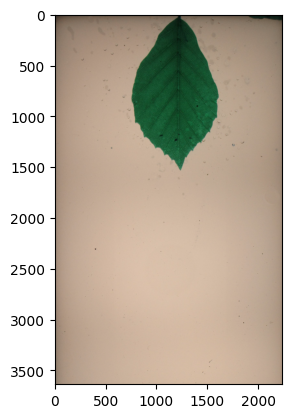

In [4]:
plt.imshow(img)
plt.show()

# Save Original Image and Create Processed

In [5]:
original = img.copy()
processed = img.copy()

# Pick Best Color Sub-Channel

In [6]:
# Image Channels
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

channels = {'RGB': ['R', 'G', 'B'], 'LAB': ['L', 'a', 'b'], 'HSV': ['H', 'S', 'V']}
images = {'RGB': img_rgb, 'LAB': img_lab, 'HSV': img_hsv}

<Figure size 4000x3000 with 0 Axes>

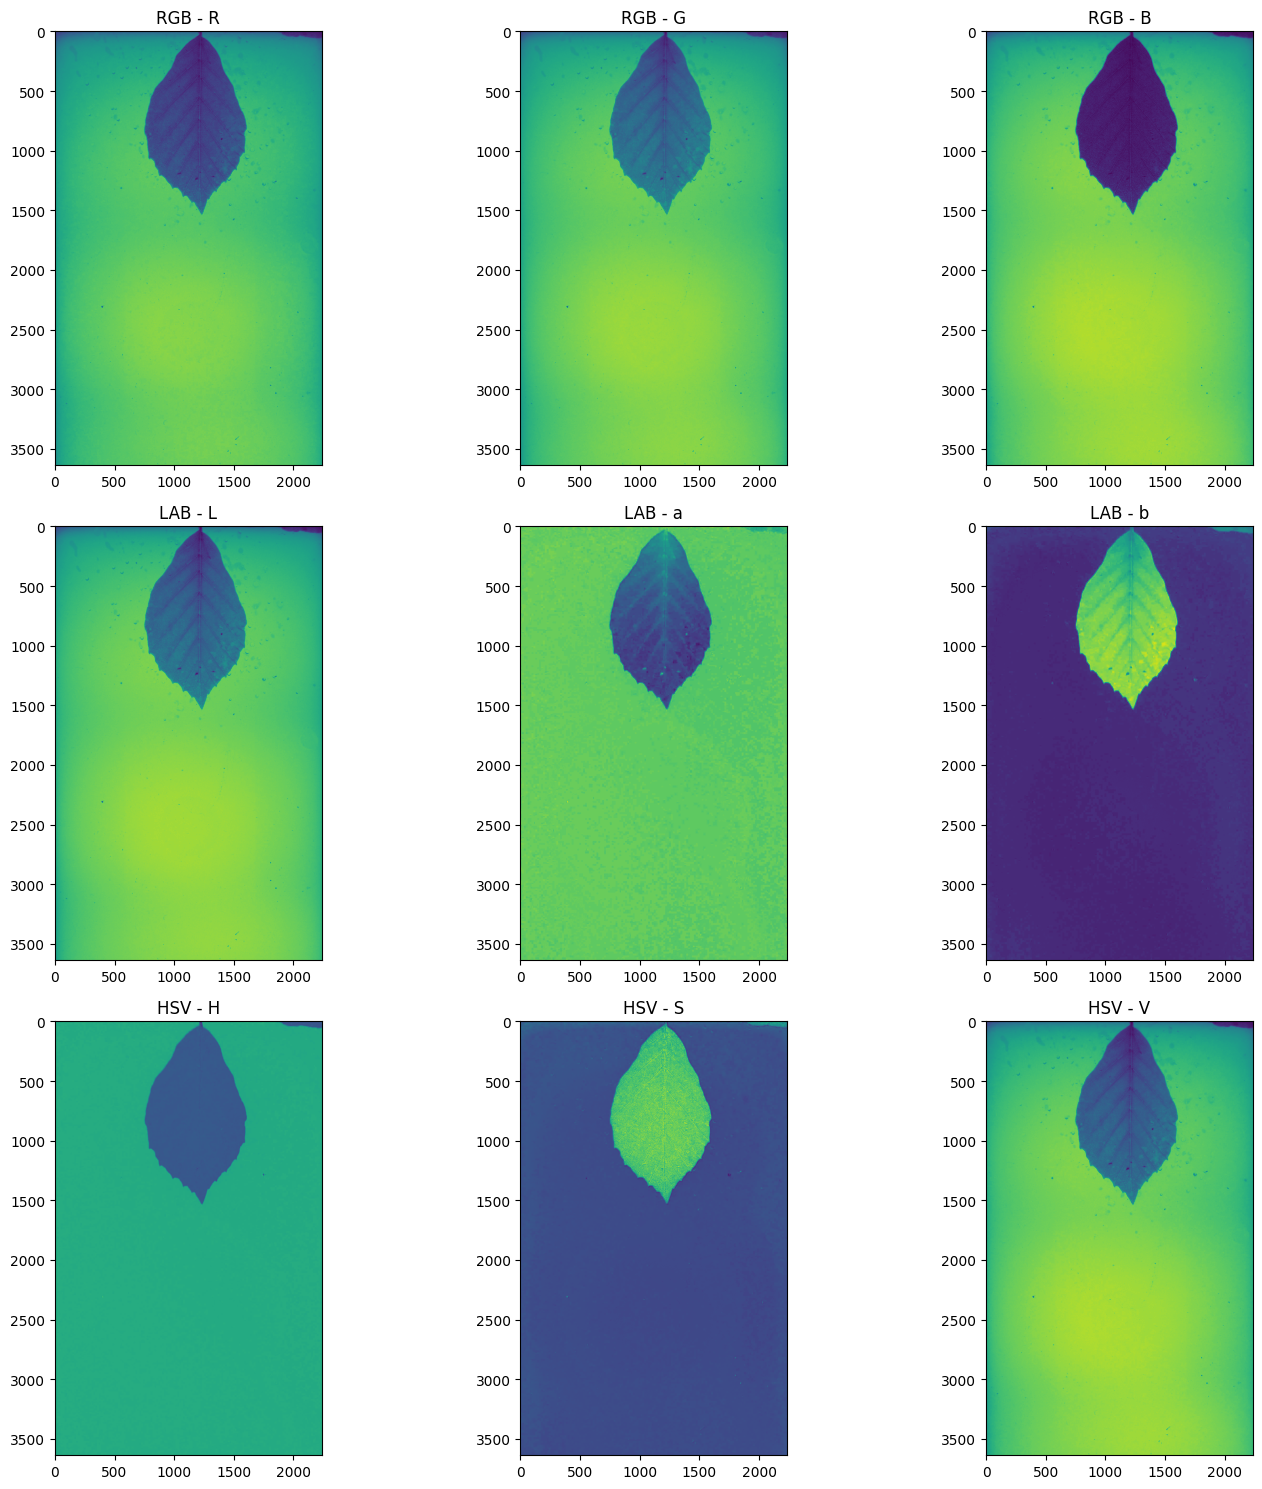

In [7]:
plt.figure(figsize=(8, 6), dpi=500)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, color_space in enumerate(channels.keys()):
    for j in range(3):
        ax[i, j].imshow(images[color_space][:, :, j])
        ax[i, j].set_title(f'{color_space} - {channels[color_space][j]}')

plt.tight_layout()
plt.show()

In [8]:
# Save the image best suited sub-channel for identifying the leaf
processed = img_hsv[:, :, 0]

In [9]:
processed.shape

(3638, 2236)

# Segment Image in Clusters

In [10]:
def kmeans(image_channel, num_clusters): 
    pixel_values = np.float32(image_channel.flatten())
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels_reshaped = labels.reshape(image_channel.shape)
    masks = [cv2.inRange(labels_reshaped, cluster_id, cluster_id) for cluster_id in range(num_clusters)]

    return masks, labels_reshaped

In [11]:
NUM_CLUSTERS = 3

masks, labels_img = kmeans(processed, NUM_CLUSTERS)  

# Pick Leaf Segment

In [12]:
masks = [None] * NUM_CLUSTERS
sizes = [0] * NUM_CLUSTERS

# Create masks for each cluster and calculate their sizes
for cluster_id in range(NUM_CLUSTERS):
    masks[cluster_id] = cv2.inRange(labels_img, cluster_id, cluster_id)
    sizes[cluster_id] = cv2.countNonZero(masks[cluster_id])

# Sort clusters by size
cluster_ids_sorted = [cluster_id for _, cluster_id in sorted(zip(sizes, range(NUM_CLUSTERS)), reverse=True)]

# Sort masks by size
masks = [masks[cluster_id] for cluster_id in cluster_ids_sorted]

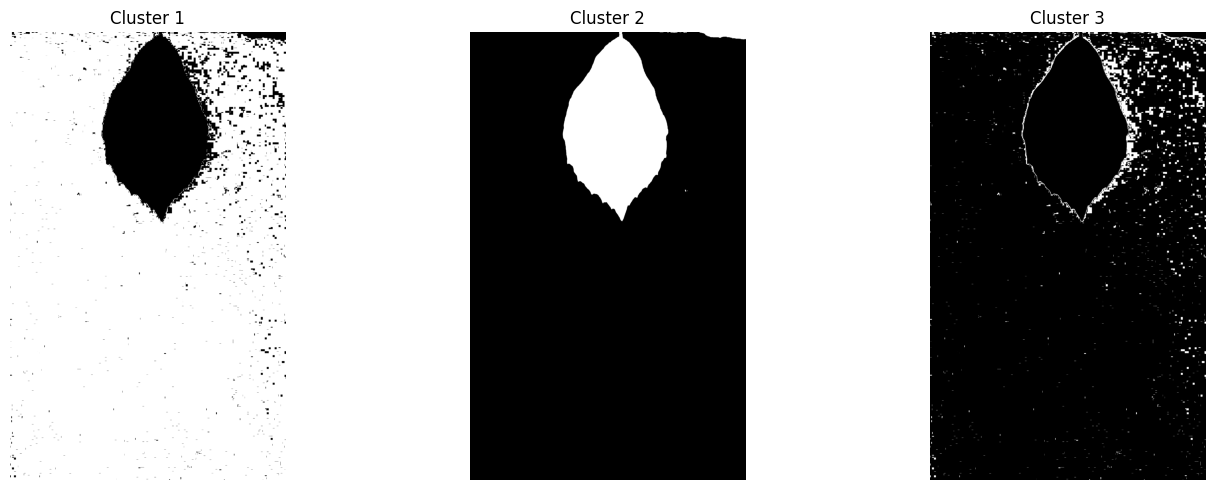

In [13]:
fig, ax = plt.subplots(1, NUM_CLUSTERS, figsize=(15, 5))

# Iterate over clusters
for i in range(NUM_CLUSTERS):
    ax[i].imshow(masks[i], cmap='gray')
    ax[i].set_title(f'Cluster {cluster_ids_sorted[i] + 1}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
mask = masks[1]

processed = cv2.bitwise_and(original, original, mask=mask)

# Set the background pixels (0 in grayscale) to white (255 in each channel)
processed[mask == 0] = [0, 0, 0]

fig, ax = plt.subplots(1,2, dpi=500)

ax[0].imshow(original)
ax[1].imshow(processed)

plt.show()

# Extract Largest Component

In [15]:
mask = np.uint8(mask)

ret, components = cv2.connectedComponents(mask, connectivity=8)

mask = np.uint8(components == np.argmax(np.bincount(components.flat)[1:]) + 1) * 255

processed = cv2.bitwise_and(processed, processed, mask=mask)

processed[mask == 0] = [200, 100, 0]


plt.figure(dpi=500)
plt.imshow(processed)
plt.show()

# Cut Stem

In [16]:
def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gray_to_binary(img):
    gray_img = bgr_to_gray(img)
    _, binary_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    return binary_img

def cut_stem(masked_img, stop_distance, kernel_size):
    binary_img = gray_to_binary(masked_img)  # changed this line
    start_row = None
    end_row = None

    for row in range(binary_img.shape[0]):
        current_row = binary_img[row, :]
        non_zero_indices = np.nonzero(current_row)[0]
    
        if non_zero_indices.size > 0:
            if start_row is None:
                start_row = row
            
            pixel_distance = np.max(non_zero_indices) - np.min(non_zero_indices)
            
            if pixel_distance > stop_distance:
                end_row = row
                break

    if (start_row is not None and end_row is not None and start_row < end_row) or start_row != 0:
        stem_region = masked_img[start_row:end_row, :]  # changed this line
        blurred_stem = median_blur(stem_region, kernel_size)
        return np.vstack((masked_img[:start_row, :], blurred_stem, masked_img[end_row:, :]))  # changed this line
    else:
        return masked_img
    
def median_blur(stem_region, kernel_size):
    return cv2.medianBlur(stem_region, kernel_size)

In [20]:
# Set pixels in 'processed' that correspond to 0 in 'mask' to [0, 0, 0]
processed[mask == 0] = [0, 0, 0]

# Convert image to grayscale (easier to work with)
gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
_, binary_img = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Initialize the starting and ending rows of the stem
start_row = None
end_row = None
stop_indices = None

# Define the stop distance
STOP_DISTANCE = 66
KERNEL_SIZE = 55

# Scan image from top to bottom
for row in range(binary_img.shape[0]):
    current_row = binary_img[row, :]
    non_zero_indices = np.nonzero(current_row)[0]
    
    if non_zero_indices.size > 0:
        # If this is the first row with non-zero elements, mark it as the start of the stem
        if start_row is None:
            start_row = row
        
        # Calculate the pixel distance between the two farthest non-zero pixels in the row
        pixel_distance = np.max(non_zero_indices) - np.min(non_zero_indices)
        
        # If the pixel distance exceeds the stop distance, mark this row as the end of the stem and break the loop
        if pixel_distance > STOP_DISTANCE:
            end_row = row
            stop_indices = [np.min(non_zero_indices), np.max(non_zero_indices)]
            break

# Apply a median blur to the stem region only if start_row and end_row are not None
if (start_row is not None and end_row is not None and start_row < end_row) or start_row != 0:
    print(f"Start row: {start_row}, End row: {end_row}")  # Print out start and end rows
    stem_region = gray[start_row:end_row, :]
    blurred_stem = cv2.medianBlur(stem_region, KERNEL_SIZE)

    # Reconstruct the image before and after blurring
    gray_before_blur = np.vstack((gray[:start_row, :], binary_img[start_row:end_row, :], gray[end_row:, :]))
    gray_after_blur = np.vstack((gray[:start_row, :], blurred_stem, gray[end_row:, :]))
else:
    print("Applying blur to the first 10 of the image")
    gray_after_blur = gray
    gray_after_blur = gray

# Convert the gray_after_blur to a binary mask
_, mask = cv2.threshold(gray_after_blur, 1, 255, cv2.THRESH_BINARY)

# Apply the new mask to the original image
processed = cv2.bitwise_and(original, original, mask=mask)

Start row: 0, End row: 53


In [21]:
processed[mask == 0] = [200, 100, 0]

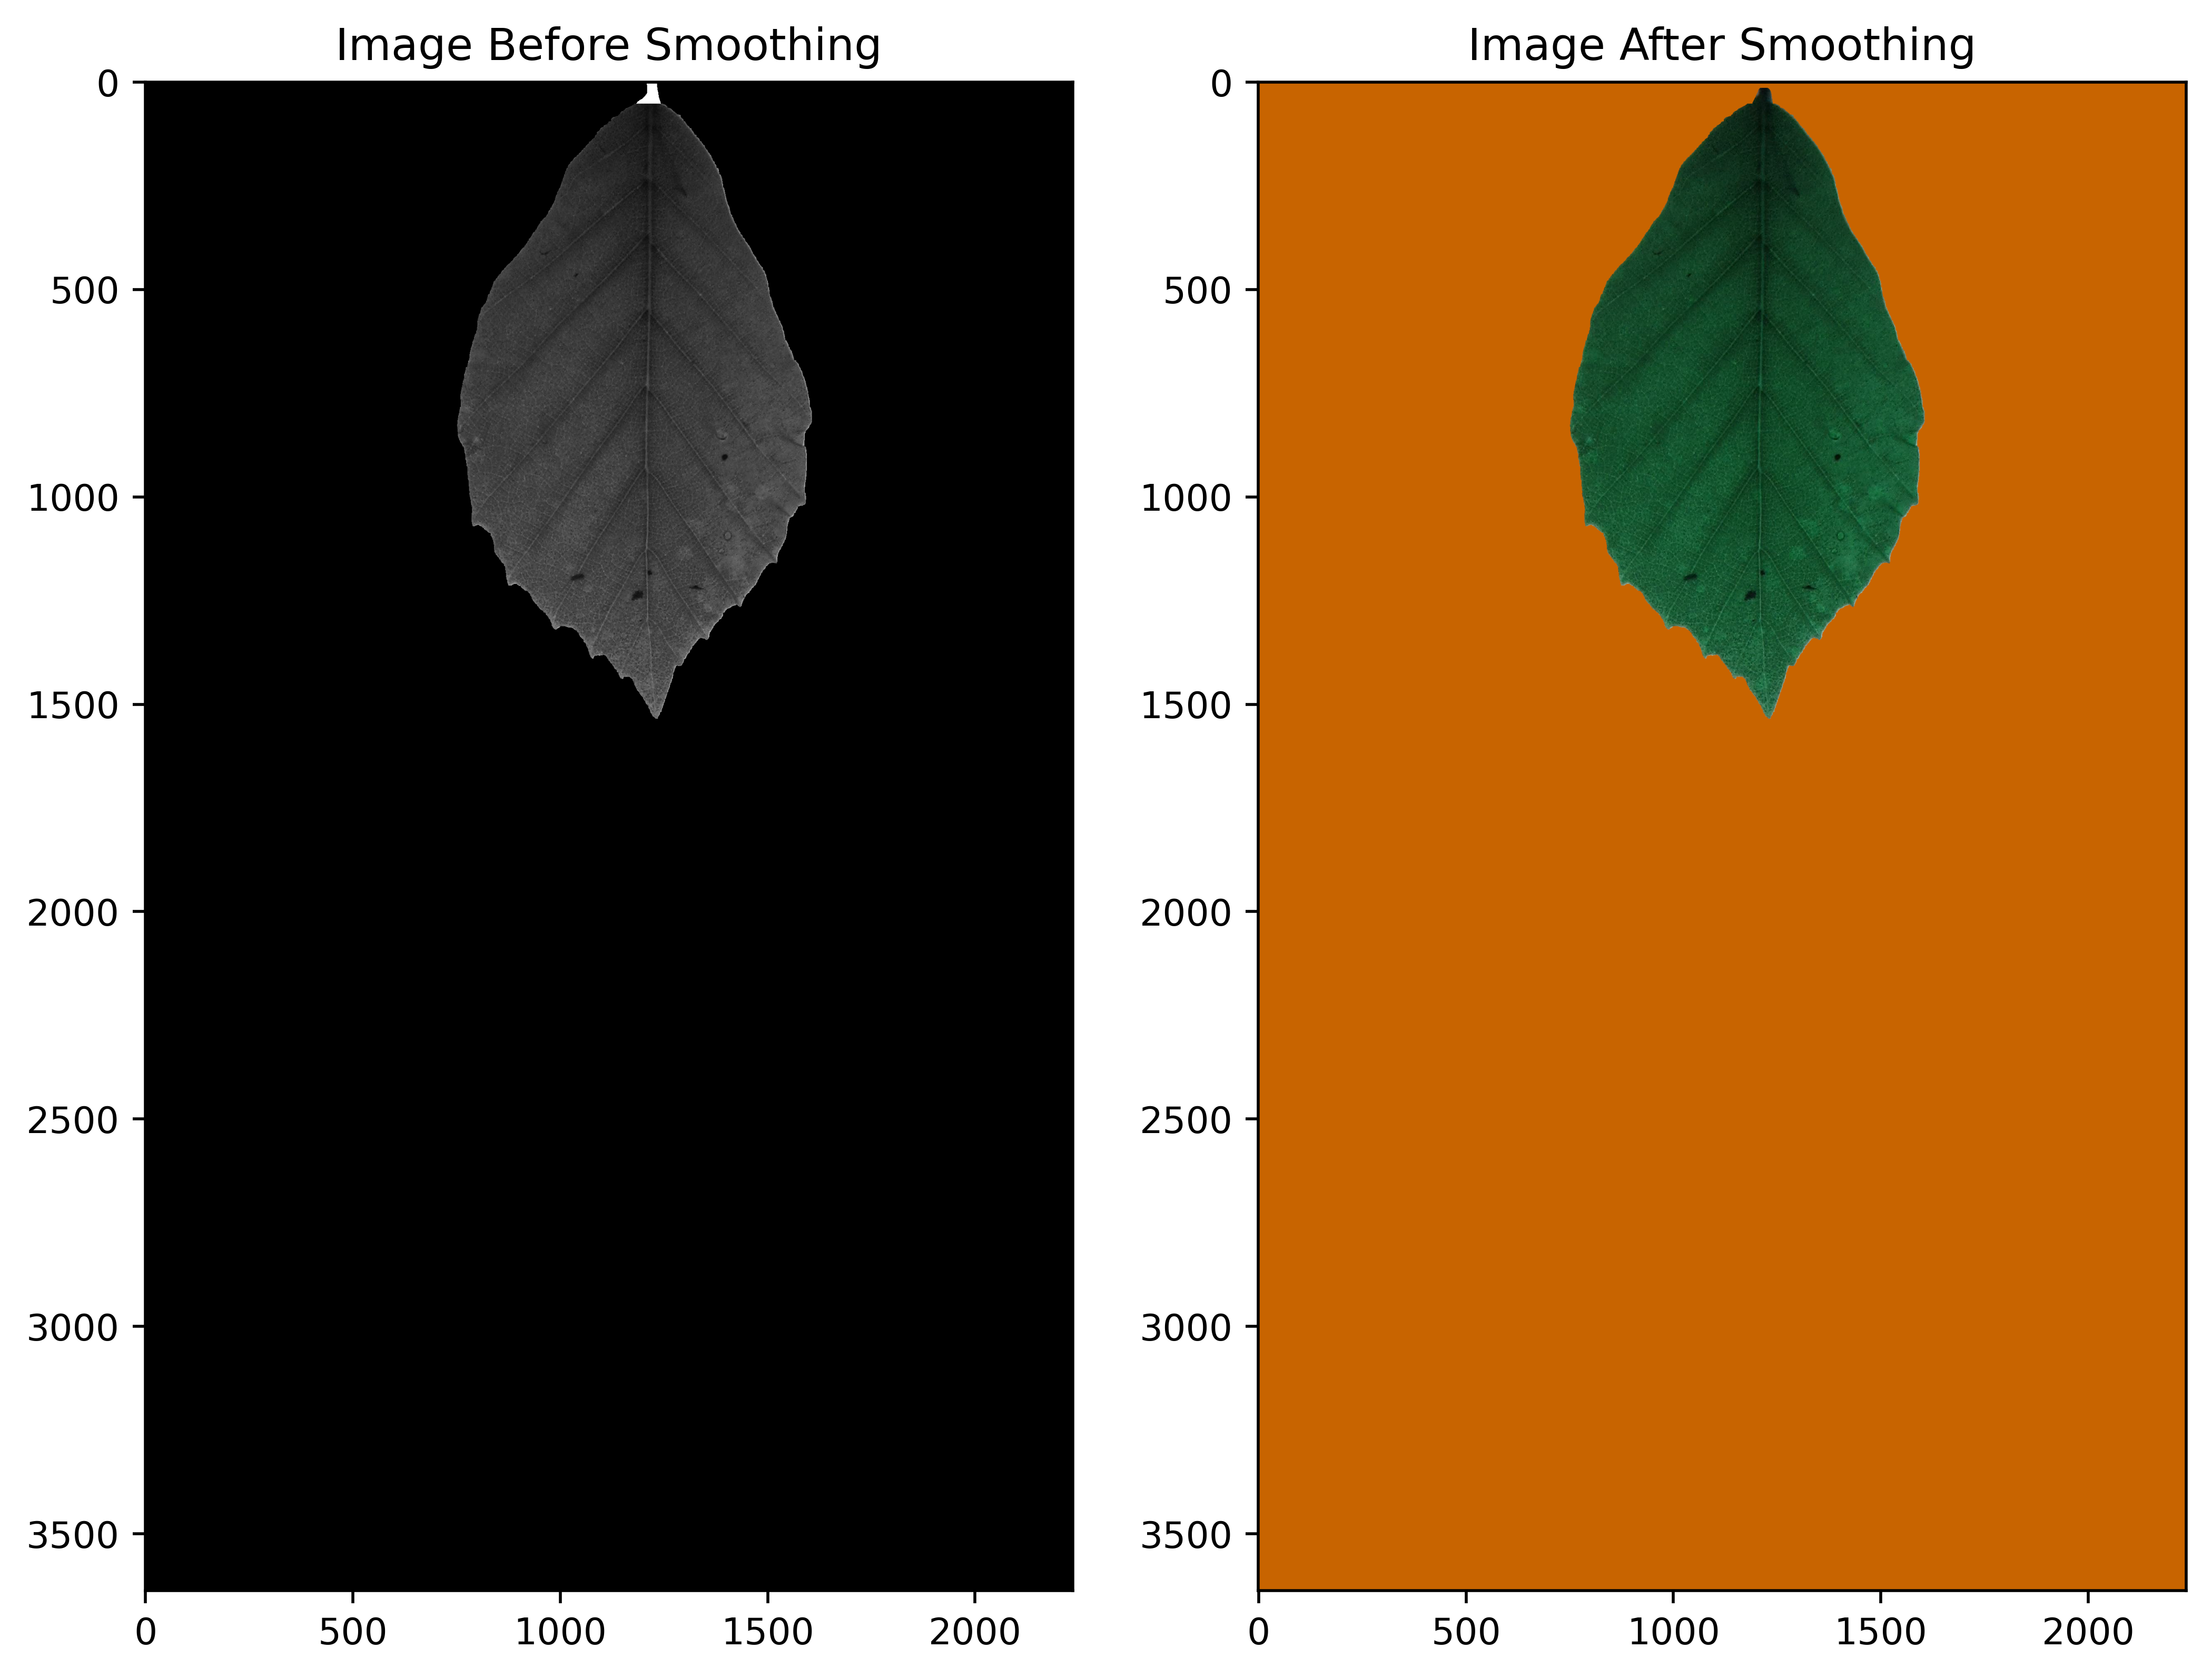

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=500)

axs[0].imshow(gray_before_blur, cmap='gray')
axs[0].set_title('Image Before Smoothing')

axs[1].imshow(processed)
axs[1].set_title('Image After Smoothing')

plt.show()